# Self Organzing Maps 
_first steps in self organzing maps_

**References**
- http://www.vahidmoosavi.com
- https://github.com/sevamoo/sompy

In [78]:
%matplotlib inline
import os
import datetime
from time import time
import numpy as np
import pandas as pd
import xarray as xr

# Moding packages
from sklearn.preprocessing import StandardScaler
import sompy

# Plotting packages
# plotting_tools is one Luke is working on, avaiable on github
import matplotlib.pyplot as plt
from plotting_tools.spatial_map import SpatialMap
from plotting_tools.time_series_diagram import TimeSeriesPlot
import cmocean as cm

### function to mask data

In [79]:
import xarray as xr
from skimage.filters import sobel

def network_mask(dir_obs='/local/data/artemis/observations'):
    '''network_mask
    This masks out regions in the 
    NCEP land-sea mask (https://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanalysis.surface.html)
    to define the open ocean. Regions removed include:
    - Coast : defined by sobel filter
    - Batymetry less than 100m
    - Arctic ocean : defined as North of 79N
    - Hudson Bay
    - caspian sea, black sea, mediterranean sea, baltic sea, Java sea, Red sea
    '''
    ### topography
    ds_topo = xr.open_dataset(f'{dir_obs}/GEBCO_2014/processed/GEBCO_2014_1x1_global.nc')
    ds_topo = ds_topo.roll(lon=180, roll_coords='lon')
    ds_topo['lon'] = np.arange(0.5, 360, 1)

    ### Loads grids
    # land-sea mask
    # land=0, sea=1
    ds_lsmask = xr.open_dataset(f'{dir_obs}/masks/originals/lsmask.nc').sortby('lat').squeeze().drop('time')
    data = ds_lsmask['mask'].where(ds_lsmask['mask']==1)
    ### Define Latitude and Longitude
    lon = ds_lsmask['lon']
    lat = ds_lsmask['lat']
    
    ### Remove coastal points, defined by sobel edge detection
    coast = (sobel(ds_lsmask['mask'])>0)
    data = data.where(coast==0)
    
    ### Remove shallow sea, less than 100m
    ### This picks out the Solomon islands and Somoa
    data = data.where(ds_topo['Height']<-100)
    
    ### remove arctic
    data = data.where(~((lat>79)))
    data = data.where(~((lat>67) & (lat<80) & (lon>20) & (lon<180)))
    data = data.where(~((lat>67) & (lat<80) & (lon>-180+360) & (lon<-100+360)))

    ### remove caspian sea, black sea, mediterranean sea, and baltic sea
    data = data.where(~((lat>24) & (lat<70) & (lon>14) & (lon<70)))
    
    ### remove hudson bay
    data = data.where(~((lat>50) & (lat<70) & (lon>-100+360) & (lon<-70+360)))
    data = data.where(~((lat>70) & (lat<80) & (lon>-130+360) & (lon<-80+360)))
    
    ### Remove Red sea
    data = data.where(~((lat>10) & (lat<25) & (lon>10) & (lon<45)))
    data = data.where(~((lat>20) & (lat<50) & (lon>0) & (lon<20)))
    
    return data

### Load data

In [80]:
dir_data = '/local/data/artemis/workspace/gloege/SOCAT-LE/data/raw/large_ensembles/CESM/member_001'

# Observations dictionary
dict_data = {'spco2': f'{dir_data}/pCO2_2D_mon_CESM001_1x1_198201-201701.nc',
             'xco2': f'{dir_data}/XCO2_1D_mon_CESM001_native_198201-201701.nc',
             'sst': f'{dir_data}/SST_2D_mon_CESM001_1x1_198201-201701.nc',
             'sss': f'{dir_data}/SSS_2D_mon_CESM001_1x1_198201-201701.nc',
             'chl': f'{dir_data}/Chl_2D_mon_CESM001_1x1_198201-201701.nc',
             'mld': f'{dir_data}/MLD_2D_mon_CESM001_1x1_198201-201701.nc'}

###  Load all variables into common dataset
ds = xr.Dataset({
    'spco2': (['time','lat', 'lon'], xr.open_dataset(dict_data['spco2'])['pCO2'].values),
    'sst':   (['time','lat', 'lon'], xr.open_dataset(dict_data['sst'])['SST'].values),
    'sss':   (['time','lat', 'lon'], xr.open_dataset(dict_data['sss'])['SSS'].values),
    #'chl':   (['time','lat', 'lon'], xr.open_dataset(dict_data['chl'])['Chl'].values),
    'mld':   (['time','lat', 'lon'], xr.open_dataset(dict_data['mld'])['MLD'].values)
    },
    
    coords={
    'lat': (['lat'], xr.open_dataset(dict_data['spco2'])['ylat'].values),
    'lon': (['lon'], xr.open_dataset(dict_data['spco2'])['xlon'].values),
    'time': (['time'], xr.open_dataset(dict_data['spco2'])['time'].values)
    })


In [81]:
# Define my network mask
mask = network_mask()

# Apply mask to dataset
ds = ds.where(mask==1)

In [84]:
# Put into dataframe
df = ds.to_dataframe().reset_index().dropna()

# Log MLD
df['mld'] = df['mld'].apply(np.log)

In [85]:
# Mean over time
means = df.groupby(['lat','lon'], as_index=False).mean()

In [86]:
means.shape

(33850, 6)

In [87]:
means.head()

,lat,lon,spco2,sst,sss,mld
0,-76.5,164.5,275.908431,-0.897485,34.624107,4.745203
1,-76.5,165.5,275.583007,-0.890498,34.615685,4.689497
2,-76.5,175.5,275.022423,-1.155173,34.392036,4.581947
3,-76.5,176.5,274.640911,-1.193554,34.363617,4.576833
4,-76.5,177.5,274.123078,-1.232818,34.334965,4.572641


### scale the data
could also normalize or transform

In [129]:
#scale the data
ss = StandardScaler().fit_transform(means[['sss','sst','mld','spco2']])
#ss = means[['sss','sst','mld','spco2']].values

In [130]:
type(ss)

numpy.ndarray

In [131]:
# Tian et al. 2013 suggest best choice for number neurons
M = 5*np.sqrt(ss.shape[0])
print(M)

m=int(np.sqrt(M))
print(m)

919.9184746487049

# Build the SOM

In [133]:
mapsize = [31,31]

# this will use the default parameters, 
#but i can change the initialization and neighborhood methods
som = sompy.SOMFactory.build(ss, 
                             mapsize, 
                             mask=None, 
                             mapshape='planar', 
                             lattice='rect', 
                             normalization='var', 
                             initialization='random', 
                             neighborhood='gaussian', 
                             training='batch', 
                             name='sompy')  

# verbose='debug' will print more, and verbose=None wont print anything
som.train(n_job=5, verbose='info',train_rough_len=10, train_finetune_len=20, ) 


 Training...
 random_initialization took: 0.000000 seconds
 Rough training...
 radius_ini: 11.000000 , radius_final: 1.833333, trainlen: 10

 epoch: 1 ---> elapsed time:  0.244000, quantization error: 0.908420

 epoch: 2 ---> elapsed time:  0.261000, quantization error: 1.506514

 epoch: 3 ---> elapsed time:  0.256000, quantization error: 1.148233

 epoch: 4 ---> elapsed time:  0.256000, quantization error: 1.065010

 epoch: 5 ---> elapsed time:  0.256000, quantization error: 0.978325

 epoch: 6 ---> elapsed time:  0.264000, quantization error: 0.883150

 epoch: 7 ---> elapsed time:  0.257000, quantization error: 0.790581

 epoch: 8 ---> elapsed time:  0.255000, quantization error: 0.698925

 epoch: 9 ---> elapsed time:  0.258000, quantization error: 0.600040

 epoch: 10 ---> elapsed time:  0.256000, quantization error: 0.491868

 Finetune training...
 radius_ini: 2.583333 , radius_final: 1.000000, trainlen: 20

 epoch: 1 ---> elapsed time:  0.256000, quantization error: 0.380832

 epo

### Put data into dataset

In [134]:
# Latitude, longitude vectors
lon = ds['lon']
lat = ds['lat']
#time = ds['time']

# create a time,lat,lon skeleton
skeleton_xr = ds.mean('time').to_dataframe().reset_index()
skeleton_xr = skeleton_xr[['lat','lon']]

# Define the number of clusters you want
map_labels_k10 = som.cluster(n_clusters=10)
data_labels_k10 = np.array([map_labels_k10[int(k)] for k in som._bmu[0]])
means['k=10'] = data_labels_k10

# merge the predictions into skeleton on the time, lat, lon coords
output = skeleton_xr.merge(means[['lat', 'lon', 'k=10']], 
                           how = 'left', on = ['lat','lon'])

# Reshape output to (lat, lon, time)
dim_time, dim_lat, dim_lon = ds['spco2'].shape
out = output['k=10'].values.reshape(dim_lat, dim_lon)

# Put into xarray dataset
ds_out = xr.Dataset(
    {
    'clusters':(['lat', 'lon'], out),
    # 'error':(['lat', 'lon', 'time'], error),
    },

    coords={
    'lat': (['lat'], lat),
    'lon': (['lon'], lon),
    })

/home/gloege/miniconda3/envs/tensorflow/lib/python3.6/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


### Plot clusters

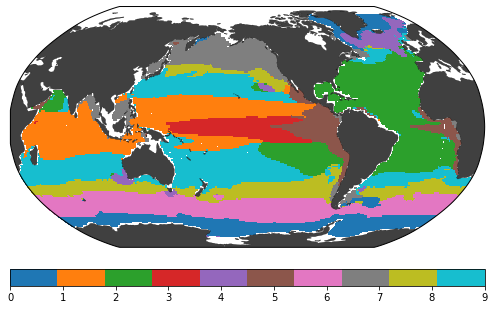

In [139]:
### Mask
dia = SpatialMap(cbar_location='bottom', cbar_orientation='horizontal')
sub = dia.add_plot(lon=ds_out['lon'], 
             lat=ds_out['lat'], 
             data=ds_out['clusters'], 
             ax=0, 
             cmap=plt.cm.tab10, 
             vrange=[0,9])
dia.add_colorbar(sub)
#plt.pcolor(ds_out['lon'], ds['lat'], ds_out['spco2'].mean('time'), vmin=280, vmax=440, cmap=cm.cm.thermal)
#plt.colorbar()

#plt.pcolor(ds_out['clusters'])

# ---- Analyzing SOM clusters ------

* http://www.cis.hut.fi/somtoolbox/package/docs2/som_quality.html

*     qe : Average distance between each data vector and its BMU.
       Measures map resolution.
*     te : Topographic error, the proportion of all data vectors
       for which first and second BMUs are not adjacent units.
       Measures topology preservation.

In [36]:
###Baseline results
te_baseline = som.calculate_topographic_error()
qe_baseline = som.calculate_quantization_error()
#optimized.__dict__

In [37]:
print(te_baseline,qe_baseline)

0.0 0.097497249900612


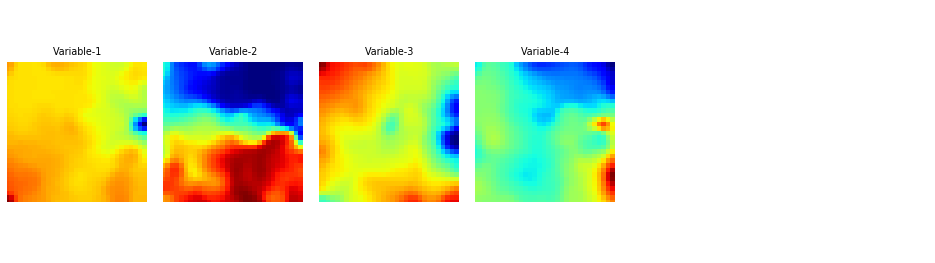

In [38]:
v = sompy.mapview.View2DPacked(40, 40, '',text_size=8)  
v.show(som, what='codebook', cmap='jet', col_sz=6) #which_dim='all' default

In [144]:
# c = sompy.mapview.View2DPacked()
v = sompy.mapview.View2DPacked(40,40, 'test',text_size=8)  
#first you can do clustering. Currently only K-means on top of the trained som
cl_5 = som.cluster(n_clusters=5)
# print cl
getattr(som, 'cluster_labels')

array([2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 1, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1,
       1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2,

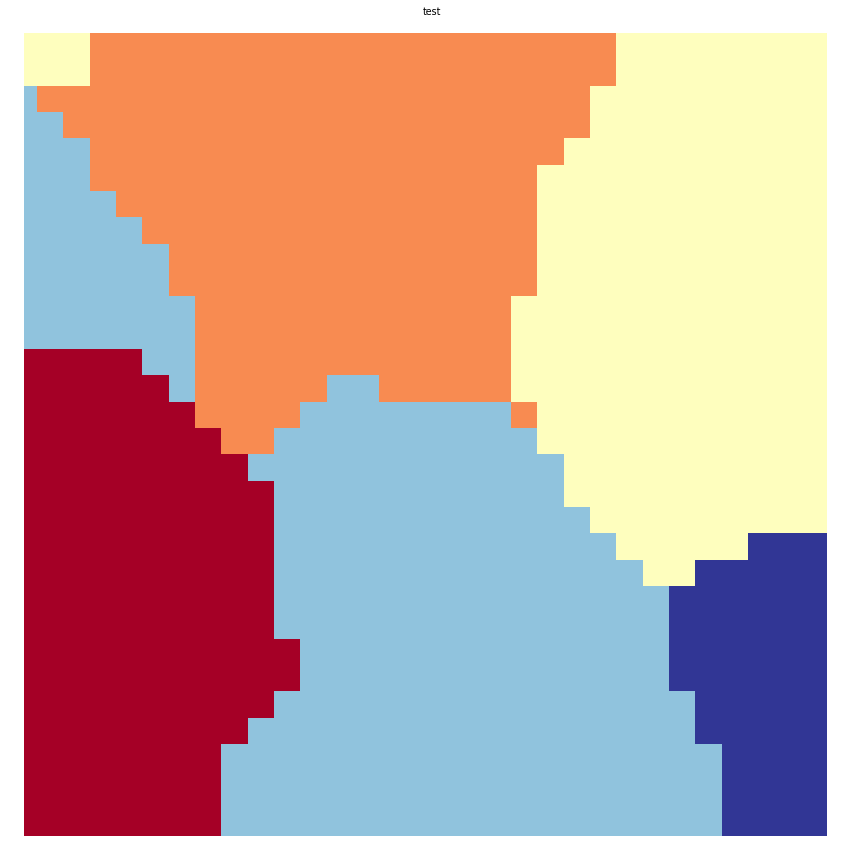

In [145]:
v.show(som, what='cluster')

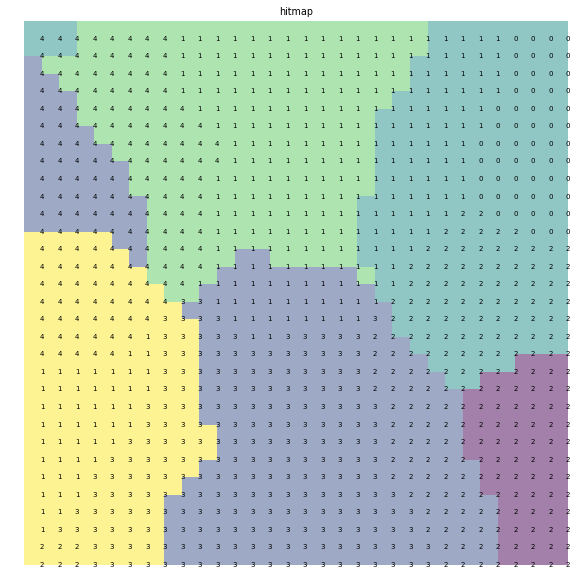

In [146]:
h = sompy.hitmap.HitMapView(10, 10, 'hitmap', text_size=8, show_text=True)
h.show(som)

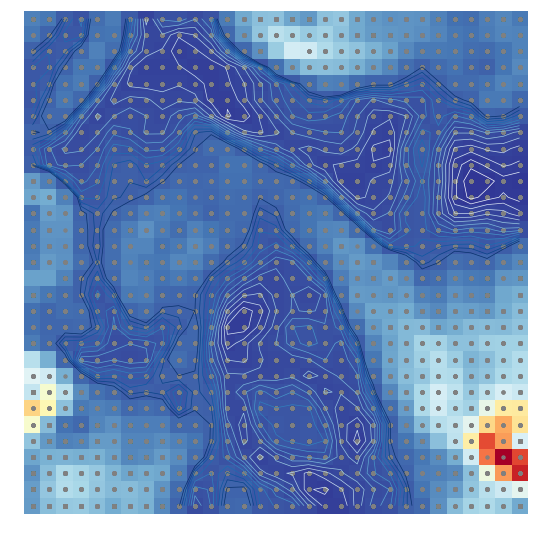

In [147]:
u = sompy.umatrix.UMatrixView(50, 50, 'umatrix', show_axis=True, text_size=8, show_text=True)

#This is the Umat value
UMAT  = u.build_u_matrix(som, distance=2, row_normalized=False)

#Here you have Umatrix plus its render
UMAT = u.show(som, distance2=1, row_normalized=False, show_data=True, contooor=True, blob=False)
